# **Hiện thực hệ thống phân loại món ăn truyền thống của Việt Nam sử dụng VGG16**
## **CE434.L21**

## **GVHD: Tran Van Cuong**

### *Dinh Pham Thien Long - 18521012*
### *Nguyen Thi Ngoc Diem - 18520597*
### *Chuong Sec Vay       - 17521252*

In [125]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification


In [126]:
import tensorflow as tf
import warnings
tf.__version__

'2.4.1'

In [127]:
# Kiểm tra GPU trong máy
# tf.config.list_physical_devices('GPU')
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [220]:
TRAIN_PATH = '/content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification/data/Train'
TEST_PATH = '/content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification/data/Test'
VALID_PATH = '/content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification/data/Validate'
MODELS_PATH = '/content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification/model/'
VISUALIZE_PATH = '/content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification/visualize/'
TEST_IMAGE = '/content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification/pho.jpg'
WIDTH = 224
HEIGHT = 224
EPOCHS = 20
BATCH_SIZE = 32

## **1. Đọc dữ liệu**




In [130]:
from tensorflow.keras.preprocessing import image
train_generator = image.ImageDataGenerator(
    rescale = 1./255,  
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 15
)
test_generator = image.ImageDataGenerator(
    rescale = 1./255,    
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 15
)
valid_generator = image.ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 15
)

In [131]:
generated_train_data = train_generator.flow_from_directory(
    TRAIN_PATH,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True, 
    seed=42
)

Found 1499 images belonging to 2 classes.


In [132]:
generated_valid_data = valid_generator.flow_from_directory(
    VALID_PATH,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed=42
)

Found 214 images belonging to 2 classes.


In [133]:
generated_test_data = test_generator.flow_from_directory(
    TEST_PATH,
    target_size = (WIDTH, HEIGHT),
    class_mode = 'categorical',
    shuffle = False,
)

Found 430 images belonging to 2 classes.


## **2. Thiết lập model**

Ở phần này, nhóm chúng em sử dụng kỹ thuật Transfer Learning để giảm thời gian train cũng như mang lại được hiệu quả hơn

In [134]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [136]:
pre_trained_model = VGG16(input_shape = (WIDTH, HEIGHT, 3), include_top = False, weights = 'imagenet')

In [137]:
# Dong bang cac layer
for layer in pre_trained_model.layers:
      layer.trainable = False

# Tao model
input = Input(shape=(WIDTH, HEIGHT, 3), name='image_input')
output_vgg16_conv = pre_trained_model(input)

# Them cac layer FC va Dropout
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', name='predictions')(x)

In [138]:
# Compile
from tensorflow.keras.optimizers import Adam
my_model = Model(inputs=input, outputs=x)
my_model.compile(optimizer = Adam(lr = 1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [139]:
vgg16_history = my_model.fit(
    generated_train_data, 
    validation_data = generated_valid_data,
    validation_steps = generated_valid_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n  // BATCH_SIZE,
    epochs = EPOCHS,
    verbose = 1
)
my_model.save(MODELS_PATH + 'vgg16.h5')

Epoch 1/20
46/46 [==============================] - 47s 1s/step - loss: 0.6637 - accuracy: 0.6704 - val_loss: 0.2344 - val_accuracy: 0.9062
Epoch 2/20
46/46 [==============================] - 46s 989ms/step - loss: 0.3055 - accuracy: 0.8667 - val_loss: 0.2052 - val_accuracy: 0.9271
Epoch 3/20
46/46 [==============================] - 45s 988ms/step - loss: 0.2227 - accuracy: 0.9126 - val_loss: 0.1802 - val_accuracy: 0.9219
Epoch 4/20
46/46 [==============================] - 46s 989ms/step - loss: 0.1637 - accuracy: 0.9297 - val_loss: 0.1836 - val_accuracy: 0.9271
Epoch 5/20
46/46 [==============================] - 46s 997ms/step - loss: 0.1564 - accuracy: 0.9469 - val_loss: 0.1302 - val_accuracy: 0.9531
Epoch 6/20
46/46 [==============================] - 47s 1s/step - loss: 0.1572 - accuracy: 0.9411 - val_loss: 0.1427 - val_accuracy: 0.9427
Epoch 7/20
46/46 [==============================] - 46s 999ms/step - loss: 0.1264 - accuracy: 0.9539 - val_loss: 0.1112 - val_accuracy: 0.9479
Epoch

## **3. Đánh giá model**


> ### *Accuracy*

> ### *Precision, Recall, f1-score*






In [140]:
y_test = generated_test_data.classes
y_pred_vgg16 = my_model.predict(generated_test_data, verbose = 1) 

14/14 [==============================] - 16s 1s/step


In [163]:
generated_train_data.class_indices.items()

dict_items([('Banh mi', 0), ('Pho', 1)])

In [169]:
df = pd.DataFrame({
    'Actual'     : generated_test_data.filenames, 
    'VGG16 prediction' : np.argmax(y_pred_vgg16, axis=1)
})  
df.head(20)

,Actual,VGG16 prediction
0,Banh mi/1006.jpg,1
1,Banh mi/1010.jpg,1
2,Banh mi/1011.jpg,0
3,Banh mi/1013.jpg,0
4,Banh mi/1014.jpg,0
5,Banh mi/102.jpg,0
6,Banh mi/1020.jpg,0
7,Banh mi/1021.jpg,0
8,Banh mi/1024.jpg,0
9,Banh mi/1025.jpg,0


In [170]:
df.tail(20)

,Actual,VGG16 prediction
410,Pho/733.jpg,1
411,Pho/735.jpg,1
412,Pho/739.jpg,1
413,Pho/743.jpg,1
414,Pho/746.jpg,1
415,Pho/756.jpg,0
416,Pho/757.jpg,1
417,Pho/76.jpg,1
418,Pho/762.jpg,0
419,Pho/77.jpg,1


In [171]:
def plot_history(history, model_name = ''):

    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    
    axes[0].plot(history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Train')
    axes[0].plot(history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Test')
    axes[0].set_xlabel('Epochs', fontsize = 14)
    axes[0].set_ylabel('Accuracy',fontsize = 14)
    axes[0].set_title(model_name + ' accuracy', fontsize = 14)
    axes[0].legend(loc = 'best')
    
    axes[1].plot(history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Train')
    axes[1].plot(history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Test')
    axes[1].set_xlabel('Epochs', fontsize = 14)
    axes[1].set_ylabel('Loss',fontsize = 14)
    axes[1].set_title(model_name + ' loss', fontsize = 14)
    axes[1].legend(loc = 'best')
    
    fig.savefig(VISUALIZE_PATH + model_name + ' evaluation.png', bbox_inches = 'tight') 
    plt.show()

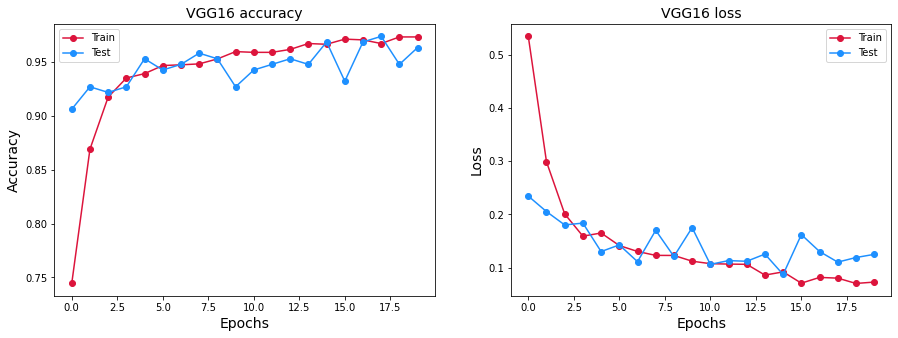

In [172]:
plot_history(vgg16_history, 'VGG16')

In [182]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

cf_matrix_vgg16 = confusion_matrix(y_test, np.argmax(y_pred_vgg16, axis=1))
print(classification_report(y_test, np.argmax(y_pred_vgg16, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       268
           1       0.93      0.96      0.95       162

    accuracy                           0.96       430
   macro avg       0.96      0.96      0.96       430
weighted avg       0.96      0.96      0.96       430



## **3. Thử nghiệm với ảnh bất kì từ trên mạng**


In [224]:
img_test = image.load_img('/content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification/banh mi.png', target_size = (WIDTH, HEIGHT))
img_test = image.img_to_array(img_test) / 255
img_test = np.expand_dims(img_test, axis = 0)
img_test.shape

(1, 224, 224, 3)

In [225]:
vgg16_model = tf.keras.models.load_model(MODELS_PATH + 'vgg16.h5')
classes = my_model.predict(img_test)

if np.argmax(classes, axis=1) == 1:
  print('Pho')
else:
  print('Banh mi')

Banh mi


In [226]:
img_test = image.load_img('/content/drive/MyDrive/COLAB_Machine Learning/Vietnames_food_Classification/pho.jpg', target_size = (WIDTH, HEIGHT))
img_test = image.img_to_array(img_test) / 255
img_test = np.expand_dims(img_test, axis = 0)
img_test.shape

(1, 224, 224, 3)

In [227]:
vgg16_model = tf.keras.models.load_model(MODELS_PATH + 'vgg16.h5')
classes = my_model.predict(img_test)

if np.argmax(classes, axis=1) == 1:
  print('Pho')
else:
  print('Banh mi')

Pho
